# Policy Optimization with more efficient samples utilization - model based control problem of RL

### Legacy repo does not work with gymnasium so some installs and hacks are needed

In [2]:
#!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

In [1]:
#!pip install gym_walk
#!pip install gymnasium

In [1]:
#import numpy as np
#import gymnasium as gym, gym_walk
#import gymnasium as gym
#from gym_walk.envs import WalkEnv

In [2]:
#from gymnasium.envs.registration import register

In [3]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.0},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [4]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditSlipperyWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.2},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [5]:
## (Stochastic) Markov Decission Problem: MDP
## s a (p(a|s), s', r, Teminal?)
#P = {
#    0: {
#        0: [(1.0, 0, 0.0, True)],
#        1: [(1.0, 0, 0.0, True)]
#    },
#    1: {
#        0: [(0.8, 0, 0.0, True), (0.2, 2, 1.0, True)],
#        1: [(0.8, 2, 1.0, True), (0.2, 0, 0.0, True)]
#    },
#    2: {
#        0: [(1.0, 2, 0.0, True)],
#        1: [(1.0, 2, 0.0, True)]
#    }
#}

In [6]:
#env = gym.make('BanditWalk-v0')

# Environment setup

### Upon installing gym_walk lib one can actuall directly instantiate envs used in the book by using proper env parameters

In [1]:
import numpy as np
from gym_walk.envs import WalkEnv

from tqdm import tqdm
import matplotlib.pyplot as plt

from itertools import count

### Slippery walk 1D AKA two-arm stochastic bandid

In [2]:
env = WalkEnv(n_states=7, p_stay=0.33, p_backward=0.16)

In [3]:
env.P

{0: {0: [(0.5099999999999999, 0, 0.0, True),
   (0.33, 0, 0.0, True),
   (0.16, 1, 0.0, False)],
  1: [(0.5099999999999999, 1, 0.0, False),
   (0.33, 0, 0.0, True),
   (0.16, 0, 0.0, True)]},
 1: {0: [(0.5099999999999999, 0, 0.0, True),
   (0.33, 1, 0.0, False),
   (0.16, 2, 0.0, False)],
  1: [(0.5099999999999999, 2, 0.0, False),
   (0.33, 1, 0.0, False),
   (0.16, 0, 0.0, True)]},
 2: {0: [(0.5099999999999999, 1, 0.0, False),
   (0.33, 2, 0.0, False),
   (0.16, 3, 0.0, False)],
  1: [(0.5099999999999999, 3, 0.0, False),
   (0.33, 2, 0.0, False),
   (0.16, 1, 0.0, False)]},
 3: {0: [(0.5099999999999999, 2, 0.0, False),
   (0.33, 3, 0.0, False),
   (0.16, 4, 0.0, False)],
  1: [(0.5099999999999999, 4, 0.0, False),
   (0.33, 3, 0.0, False),
   (0.16, 2, 0.0, False)]},
 4: {0: [(0.5099999999999999, 3, 0.0, False),
   (0.33, 4, 0.0, False),
   (0.16, 5, 0.0, False)],
  1: [(0.5099999999999999, 5, 0.0, False),
   (0.33, 4, 0.0, False),
   (0.16, 3, 0.0, False)]},
 5: {0: [(0.50999999999999

In [4]:
env.reset()

(4, {'prob': 1.0})

In [5]:
env.step(1)

(4, 0.0, False, False, {'prob': 0.33, 'success': False})

## MC policy evaluation

In [6]:
env.action_space

Discrete(2)

In [7]:
env.action_space.n

2

In [8]:
# 10^{-3...0} every 1/10, so we get 10 points of 10 raised to linear space power in the range [-3, 0]
np.logspace(-2, 0, 10, base=10, endpoint=True)

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

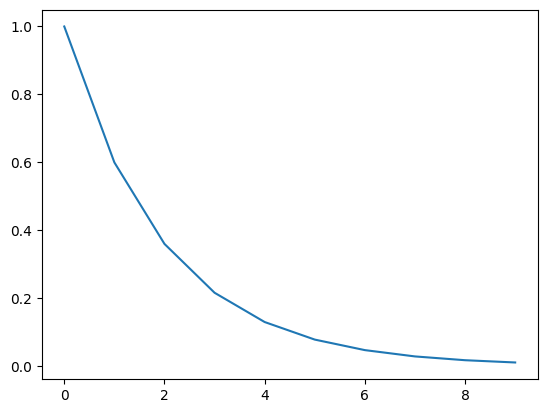

In [94]:
plt.plot(np.logspace(-2, 0, 10, base=10, endpoint=True)[::-1])

In [6]:
def decay_schedule(init_value,
                   min_value,
                   decay_ratio,
                   max_steps,
                   log_start=-2,
                   log_base=10):
    
    decay_steps = int(decay_ratio * max_steps)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min())/(values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    # padding (0, rem_steps) padds 0 elements on the left and rem_steps elements on the right, with edge value
    values = np.pad(values, (0, rem_steps), 'edge')
    
    return values

## SARSA(\lambda) with replacing eligibility traces

In [9]:
def sarsa_lambda(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=0.5,
          min_epsilon=0.01,
          epsilon_decay_ratio=0.9,
          n_episodes=3000,
          lambda_=0.5,
          replacing_traces=True):
    nS, nA = env.observation_space.n, env.action_space.n
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    E = np.zeros((nS, nA), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if np.random.random() > epsilon else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        
        state, done = env.reset()[0], False
        action = select_action(state, Q, epsilons[e])
    
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]

            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
                
            Q = Q + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            
            state, acton = next_state, next_action
            
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track

In [10]:
Q_s, V_t, pi, Q_track, pi_track = sarsa_lambda(env)

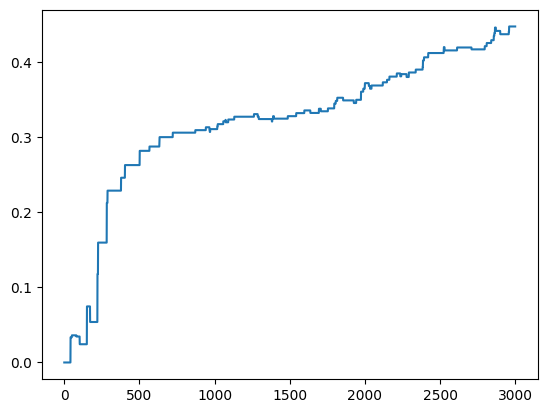

In [11]:
plt.plot(Q_track[:, 1, 1])

In [21]:
V_t

array([0.        , 0.46703682, 0.79947859, 0.9139864 , 0.96611605,
       0.98628231, 0.99193206, 0.9970668 , 0.        ])

## Watkins Q(\lambda) - Q-learning with replacing eligibility traces
### This again converges faster than SARSA(\lambda) above

In [4]:
def q_lambda(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=0.5,
          min_epsilon=0.01,
          epsilon_decay_ratio=0.9,
          n_episodes=3000,
          lambda_=0.5,
          replacing_traces=True):
    nS, nA = env.observation_space.n, env.action_space.n
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    E = np.zeros((nS, nA), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if np.random.random() > epsilon else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        
        state, done = env.reset()[0], False
        # This is absent in Q-learning (where next action is taken greedly withing Q update rule)
        # but here it is needed like in SARSA for testing if action is selected greedily
        # to adjust eligibility traces accordngly
        action = select_action(state, Q, epsilons[e])
    
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])

            # This test will condition wether eligibility trace will get an update
            # Only greedy next_actions will get one in order to enforce 
            # converging to the greedy policy 
            next_action_is_greedy = \
                Q[next_state][next_action] == Q[next_state].max()
            
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]

            # In this replacing traces approach the whole trace of a given state (i.e. for all its actions)
            # is cleared
            if replacing_traces: E.fill(0)
            E[state][action] = E[state][action] + 1
            Q = Q + alphas[e] * td_error * E
            # If action is greedy we allow for updates accumulaton across subsequent episode steps
            if next_action_is_greedy:
                E = gamma * lambda_ * E
            else:
                # if suboptimal action is taken (non-greedy) then we clear the resulting accumulation of
                # this particular state-action pair
                E.fill(0)
            
            state, acton = next_state, next_action
            
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track

In [5]:
Q_s, V_t, pi, Q_track, pi_track = q_lambda(env)

In [6]:
V_t

array([0.        , 0.52063584, 0.82387638, 0.94943825, 0.98423483,
       0.99583252, 0.99861287, 0.99965963, 0.        ])

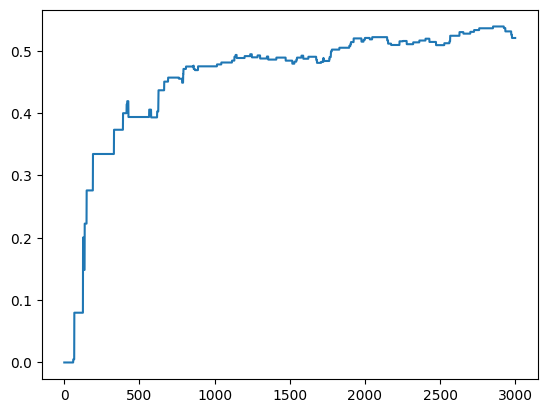

In [8]:
plt.plot(Q_track[:, 1, 1])

## Dyna-Q - learning a MDP model from sampled env interaction to increase sample efficiency

In [11]:
def dyna_q(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=0.5,
          min_epsilon=0.01,
          epsilon_decay_ratio=0.9,
          n_episodes=3000,
          n_planning=3):
    nS, nA = env.observation_space.n, env.action_space.n
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    # The "model" of MDP
    T_count  = np.zeros((nS, nA, nS), dtype=np.int64)
    R_model  = np.zeros((nS, nA, nS), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if np.random.random() > epsilon else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):    
        state, done = env.reset()[0], False
    
        while not done:
            # In-loop action selection like in Q-learning
            action = select_action(state, Q, epsilons[e])

            next_state, reward, done, _, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])

            # Model "training" step after env sample collected
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += r_diff / (T_count[state][action][next_state])
            # Off-policy TD update with greedy action like in Q-learning
            td_target = reward + gamma * Q[next_state][next_action].max() * (not done)
            td_error = td_target - Q[state][action]
                
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            backup_next_state = next_state

            # Plannig based Q update
            for _ in range(n_planning):
                if Q.sum() == 0: break
                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                # In Dyna-Q we sample the whole (visited) state space uniformly
                # regardless of the current episode progression
                # (we are here within the given episode loop)
                state = np.random.choice(visited_states)

                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                # Now we model empirical transition probabilities to next_states
                probs = T_count[state][action] / T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]

                reward = R_model[state][action][next_state]
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] += alphas[e] * td_error

            state = backup_next_state
        
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track

In [12]:
Q_s, V_t, pi, Q_track, pi_track = dyna_q(env)

In [13]:
V_t

array([0.        , 0.66509627, 0.90072719, 0.96097227, 0.98849485,
       0.99667493, 0.99918661, 0.99982222, 0.        ])

#### Model based methods have high error spikes early on due to large initial environment model inaccuracy, but converges faster (per real env sampling step) due to more updates done to Q value per episode passage

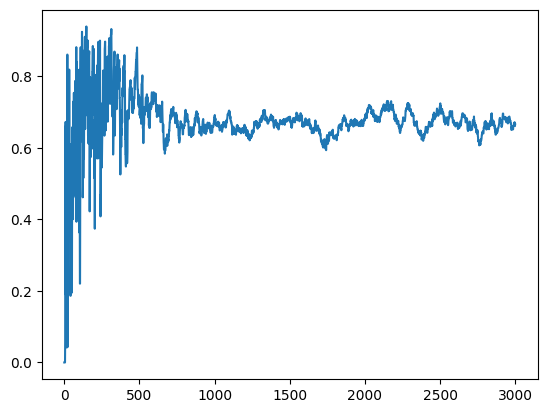

In [14]:
plt.plot(Q_track[:, 1, 1])

## Trajectory sampling - Dyna-Q with episode-likely state-action sampling

In [12]:
def trajectory_sampling(env,
          gamma=1.0,  
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=0.5,
          min_epsilon=0.01,
          epsilon_decay_ratio= 0.9,
          n_episodes=3000,
          max_trajectory_depth=100):
    nS, nA = env.observation_space.n, env.action_space.n
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = [] 
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    # The "model" of MDP
    T_count  = np.zeros((nS, nA, nS), dtype=np.int64)
    R_model  = np.zeros((nS, nA, nS), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if np.random.random() > epsilon else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):    
        state, done = env.reset()[0], False
    
        while not done:
            # In-loop action selection like in Q-learning
            action = select_action(state, Q, epsilons[e])

            next_state, reward, done, _, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])

            # Model "training" step after env sample collected
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += r_diff / (T_count[state][action][next_state])
            # Off-policy TD update with greedy action like in Q-learning
            td_target = reward + gamma * Q[next_state][next_action].max() * (not done)
            td_error = td_target - Q[state][action]
                
            Q[state][action] += alphas[e] * td_error
             
            backup_next_state = next_state

            # Plannig based Q update
            for _ in range(max_trajectory_depth) :
                if Q.sum() == 0: break
                
                # Main point of trajectory sampling: selecting next action
                # like in standard TD/SARSA/Q methods to 'virtually' follow up on the state from
                # the current epoch state (in the loop one level up)
                # After performing the update the ordinary sampling-based episode continuation will
                # resume
                # On or Off policy action selection
                # action = select_action(state, Q, epsilons[e])
                action = Q[state].argmax()
                # Checking if action was taken ever before
                if not T_count[state][action].sum(): break
                
                # Now we model empirical transition probabilities to next_states
                probs = T_count[state][action] / T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]

                reward = R_model[state][action][next_state]
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] += alphas[e] * td_error

                # 'Virtual' follow-up of the trajectory in the planning phase of
                # this internal loop
                state = next_state
            
            # Going back to the env sampling phase of the episode loop and
            # continuing 'real' follow-ups of the state
            state = backup_next_state
        
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track 

In [11]:
Q_s, V_t, pi, Q_track, pi_track = trajectory_sampling(env)

In [13]:
V_t

array([0.        , 0.72443048, 0.90657872, 0.97095444, 0.99125808,
       0.99725871, 0.99918783, 0.99979215, 0.        ])

#### Same as with Dyna-Q, model based methods have high error spikes early on due to large initial environment model inaccuracy, but converges faster (per real env sampling step) due to more updates done to Q value per episode passage

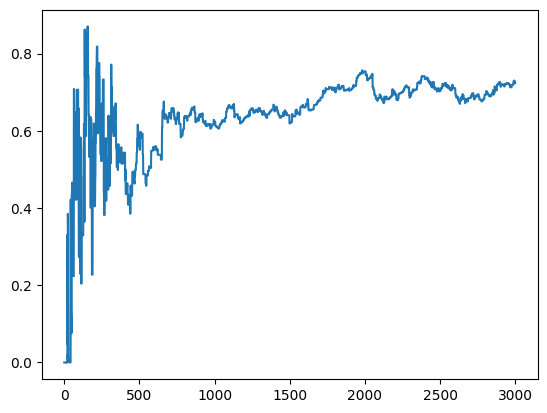

In [14]:
plt.plot(Q_track[:, 1, 1])